In [1]:
import os
import os.path as osp
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imsave, imread
from skimage import img_as_ubyte, img_as_float
import sys
import monai

%load_ext autoreload
%autoreload 2

In [65]:
def imshow_pair(im, gdt, vmin1=None, vmax1=None, vmin2=None, vmax2=None):
    f, ax = plt.subplots(1, 2, figsize=(10,5))
    np_im = np.asarray(im)
    np_gdt = np.asarray(gdt)
    if len(np_im.shape) == 2:
        if vmin1==None:
            ax[0].imshow(np_im, cmap='gray'),  ax[0].axis('off')
        else:
            ax[0].imshow(np_im, cmap='gray', vmin=vmin1, vmax=vmax1),  ax[0].axis('off')
    else:
        ax[0].imshow(np_im),  ax[0].axis('off')
    if len(np_gdt.shape) == 2:
        if vmin2==None:
            ax[1].imshow(np.asarray(gdt), cmap = 'gray', vmin=vmin2, vmax=vmax2), ax[1].axis('off')
        else:
            ax[1].imshow(np.asarray(gdt), cmap = 'gray'), ax[1].axis('off')
    else:
        ax[1].imshow(np.asarray(gdt)), ax[1].axis('off')
    plt.tight_layout()

Monai transforms at the **array** level: Transforms in MONAI are callable objects accepting inputs from like data or output coming from previous transforms. 

We can create and call transforms directly without any infrastructure or system setup as components in MONAI are designed to be as decoupled as possible.

In [3]:
from monai.transforms import (
    Transform,
    Randomizable,
    Compose,
    Lambda,
    RandSpatialCrop,
    ToTensor,
    LoadImage,
)

In [60]:
filenames = list(pd.read_csv('data/DRIVE/train_av.csv').im_paths)

In [61]:
trans = LoadImage(dtype=np.uint8, image_only=True)

In [62]:
img= trans(filenames[0])

In [63]:
type(img)

itk.itkPyBufferPython.NDArrayITKBase

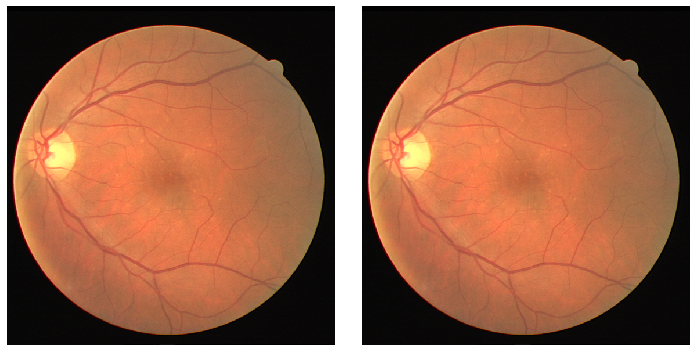

In [66]:
imshow_pair(img,img)

Transforms are composed with `Compose` to create a sequence of operations. `Compose` itself being a transform we can also call it directly:

In [67]:
trans = Compose([LoadImage(dtype=np.uint8, image_only=True), ToTensor()])

img = trans(filenames[0])

print(img.shape)

torch.Size([584, 565, 3])


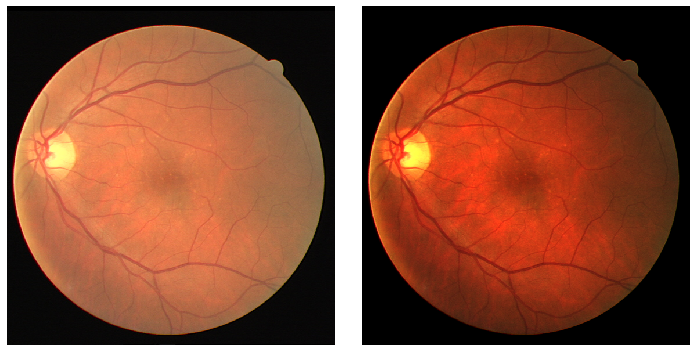

In [69]:
def gamma_op(img):
    return (img/255.)**2


trans = Compose([LoadImage(dtype=np.uint8, image_only=True), Lambda(gamma_op)])

img_t = trans(filenames[0])

imshow_pair(img, img_t)

Creating a subclass of Transform is the second method, and this has the advantage of being able to define attributes with the instantiated objects. Let's define a class to apply a gamma operation with fixable parameter:

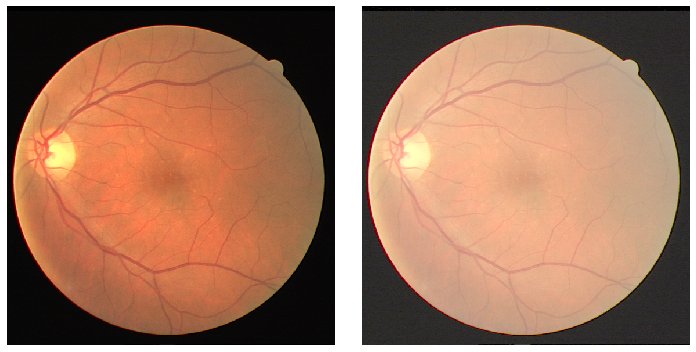

In [79]:
class Gamma(Transform):
    def __init__(self, gamma=1):
        self.gamma = gamma
    
    def gamma_op(self, img):
        return (img/255.)**self.gamma

    def __call__(self, inputs):
        return self.gamma_op(inputs)


trans = Compose([LoadImage(dtype=np.uint8, image_only=True), Gamma(0.5)])

img_t = trans(filenames[0])

imshow_pair(img, img_t)

All of these example transforms so far have been deterministic, to define transforms which perform some stochastic operation on input data we want to also inherit from `Randomizable`. This class is used to randomize variables but also distinguish from deterministic transforms. We'll see why this is important later in caching data loaders. For now lets define a simple transform to add

Run this cell a few times to see the random transform being applied 50% of the time.

In this class we have a `numpy.random.RandomState` object to provide stochastic values. This can be replaced using `Randomizable.set_random_state()` to control the randomization process. The `randomize()` method is responsible for determining if the random operation is to be performed based on the `prob` probability member, then creates the random noise array if so. This functionality is in this method so that it can be called by `Compose` or other external controllers. 

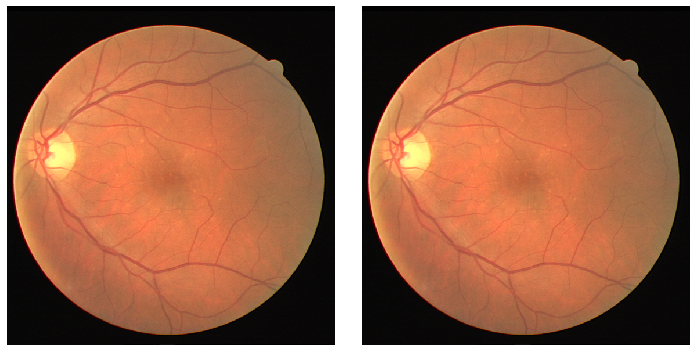

In [101]:
class RandGamma(Randomizable, Transform):
    def __init__(self, prob: float = 0.5, min_gamma: float = 0.5, max_gamma: float = 2.0) -> None:
        self.prob = np.clip(prob, 0.0, 1.0)
        self.min_gamma = min_gamma
        self.max_gamma = max_gamma
        self._gamma = 1
        
    def randomize(self) -> None:
        self._gamma = 1

        if self.R.random() < self.prob:
            self._gamma = self.R.uniform(low=self.min_gamma, high=self.max_gamma)

    def gamma_op(self, img: np.ndarray) -> np.ndarray:
        return (img/255.)**self._gamma

    def __call__(self, img: np.ndarray) -> np.ndarray:
        self.randomize()
        return self.gamma_op(img)


trans = Compose([LoadImage(dtype=np.uint8, image_only=True), RandGamma(prob=0.5)])

img_t = trans(filenames[0])

imshow_pair(img, img_t)

## Dictionary Transforms

So far we have seen transforms which are applied to individual Numpy arrays, however for most training schemes a pipeline with multiple values is needed. To address this MONAI includes transforms for operating on dictionaries of arrays, one for each equivalent array transform. These can be applied to named values in an input dictionary while leaving unnamed values untouched, for example adding noise to an image while leaving the associated label image untouched. 

We then import the dictionary equivalent transforms which have a `d` or `D` appended to their names:

In [104]:
from monai.transforms import (
    LoadImageD,
    LambdaD,
    ToTensorD,
)

In [105]:
img_names = list(pd.read_csv('data/DRIVE/train_av.csv').im_paths)
seg_names = list(pd.read_csv('data/DRIVE/train_av.csv').gt_paths)

In [113]:
fn_keys = ('img', 'seg')  # filename keys for image and seg files
filenames = [{'img': x, 'seg': y} for x,y in zip(img_names, seg_names)]

Lambdad applies the given callable to each array named by keys separately. We can use this to define transforms operating on different named values in the dictionary:

In [538]:
def gamma_op(img):
    return (img/255.)**2


trans = Compose(
    [
        LoadImageD(keys=('img', 'seg'), dtype=np.uint8 ),
        Lambdad(('img',), gamma_op),  # apply gamma only on image
    ]
)

imgd = trans(filenames[0])
img = imgd["img"]
seg = imgd["seg"]

In [539]:
img.shape

(584, 565, 3)

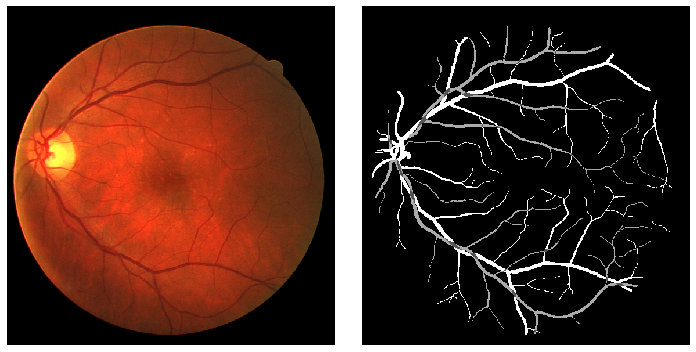

In [118]:
imshow_pair(img, seg)

The above applies one operation to one member of the dictionary and different operation to another. A reasonable re-implementation of this in one transform would require retaining the names of which members to apply which transform to and applying the operations in one method.

Adapting array-based transforms to operate over dictionaries is relatively straight-forward. We will be needing our class to inherit from MapTransform besides Randomizable, have a look here:

https://docs.monai.io/en/latest/transforms.html#maptransform


In [120]:
from monai.transforms import MapTransform

# for type hinting at this stage we need more
from monai.config import KeysCollection
from typing import Optional, Any, Mapping, Hashable

There is also some funky staff. We create an instance of the non-dictionary version of the transform inside the dictionary-based transform object! This allows us to keep track of random states and apply exactly the same random transform to different members in our dict. 

Let us recall the non-dictionary class here:

In [121]:
class RandGamma(Randomizable, Transform):
    def __init__(self, prob: float = 0.5, min_gamma: float = 0.5, max_gamma: float = 2.0) -> None:
        self.prob = np.clip(prob, 0.0, 1.0)
        self.min_gamma = min_gamma
        self.max_gamma = max_gamma
        self._gamma = 1
        
    def randomize(self) -> None:
        self._gamma = 1

        if self.R.random() < self.prob:
            self._gamma = self.R.uniform(low=self.min_gamma, high=self.max_gamma)

    def gamma_op(self, img: np.ndarray) -> np.ndarray:
        return (img/255.)**self._gamma

    def __call__(self, img: np.ndarray) -> np.ndarray:
        self.randomize()
        return self.gamma_op(img)


Let us call that internal instance a "delegate", which we store inside the attribute "transform". Then we have:

* `set_random_state` sets the state of the delegate and the current object
* `randomize` delegates the randomization to the `RandAdditiveNoise` instance
* `__call__` causes the delegate to randomize then applies the transform to each named member of the dictionary. 

The delegate transform is randomized only once, this ensures the same random field is added to each named member of the dictionary, a slightly different implementation adding a per-key random field would be needed if this were the desired behaviour. 

In [132]:
class RandGammaD(Randomizable, MapTransform):
    def __init__(self, keys: KeysCollection, 
                 prob: float = 0.5, 
                 min_gamma: float = 0.5, 
                 max_gamma: float = 2.0) -> None:
        
        super(Randomizable, self).__init__(keys)
        self.transform = RandGamma(prob, min_gamma, max_gamma) # our delegate!
        
        
    def set_random_state(self, seed: Optional[int] = None, state: 
                         Optional[np.random.RandomState] = None) -> 'RandGammaD':
        self.transform.set_random_state(seed, state) # sets the state of the delegate
        super().set_random_state(seed, state) # sets the state of the current object
        return self
    
    def randomize(self, data: Optional[Any] = None) -> None:
        self.transform.randomize()
        
    def __call__(self, data: Mapping[Hashable, np.ndarray]) -> Mapping[Hashable, np.ndarray]:
#         self.randomize(data[monai.utils.first(self.keys)]) # the delegate is randomized with data[first]?
        self.randomize() # the delegate is randomized
        d = dict(data)
        for key in self.keys:
            d[key] = self.transform.gamma_op(d[key])
        return d

In [133]:
trans = Compose(
    [
        LoadImageD(keys=('img', 'seg'), dtype=np.uint8),
        RandGammaD(('img',) ),  # apply gamma only on image
    ]
)

imgd = trans(filenames[0])
img = imgd["img"]
seg = imgd["seg"]

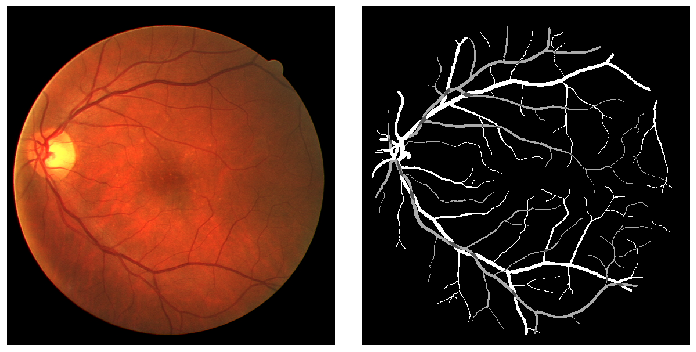

In [134]:
imshow_pair(img, seg)

## Loading Datasets

With a data source and transforms defined we can now create a dataset object. The base class for MONAI is `Dataset`, created here to load the image files only:

In [140]:
from monai.data import Dataset, ArrayDataset

In [138]:
images = [fn['img'] for fn in filenames]

transform = Compose([LoadImage(dtype=np.uint8, image_only=True), ToTensor()])

ds = Dataset(images, transform)

img_tensor = ds[0]

print(img_tensor.shape, img_tensor.get_device())

torch.Size([584, 565, 3]) -1


`Dataset` inherits from the Pytorch class of that name and adds only the ability to apply the given transform to selected items. If you're familiar with the class from Pytorch this will work the same way. 

MONAI provides the `ArrayDataset` for supervised training applications specifically. It can accept data arrays for images separate from those for segmentations or labels with their own separate transforms. Here we will again separate out the image and segmentation filenames to demonstrate this usage:

In [150]:
from monai.transforms import AddChannel, AsChannelFirst

In [162]:
images = [fn["img"] for fn in filenames]
segs = [fn["seg"] for fn in filenames]

img_transform = Compose(
    [
        LoadImage(dtype=np.uint8, image_only=True),
        AsChannelFirst(),
        RandSpatialCrop((256, 256), random_size=False),
        RandGamma(),
        ToTensor(),
    ]
)

seg_transform = Compose(
    [
        LoadImage(dtype=np.uint8, image_only=True),
        AddChannel(),
        RandSpatialCrop((256, 256), random_size=False),
        ToTensor(),
    ]
)



Instead of returning a single image, accessing a member of the dataset produces a pair containing the image and segmentation after being pass through their respective transforms. One important aspect of this class is that the random state of each transform (`Compose` in this case) is set to that of the dataset before being applied. This ensures the same random operations are applied to each output, which is why the `RandSpatialCrop` operation chooses the same crop window for the image as well as the segmentation. By having separate transforms one can apply operations to images and not to segmentations (or vice versa), being careful that these unshared operations come after the shared ones.

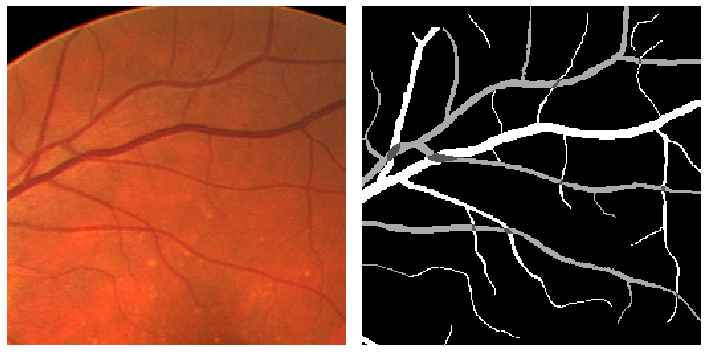

In [164]:
ds = ArrayDataset(images, img_transform, segs, seg_transform)
im, seg = ds[0]

imshow_pair(im.numpy().transpose(1,2,0), seg[0])

Alternatively, `Dataset` can be used with dictionary-based transforms to construct a result mapping. For training applications beyond simple input/ground-truth pairs like the above this would be more suitable:

In [607]:
from monai.transforms import AddChannelD, AsChannelFirstD, RandSpatialCropD, \
                            ScaleIntensityD, RandAdjustContrastD, RandRotateD, RandAffineD, \
                            Rand2DElasticD, RandFlipD, RandZoomD, CropForegroundd

In [625]:
trans = Compose(
    [
        LoadImageD(keys=('img', 'seg'), dtype=np.uint8 ),
        AsChannelFirstD(keys=('img',)),
        AddChannelD(keys=('seg',)),
        CropForegroundd(keys=('img','seg'), source_key='seg'),
        ScaleIntensityD(keys=('img',)),
        RandAdjustContrastD(keys=('img',), prob=0.25, gamma=(0.5, 2.5)),
        RandAffineD(keys=('img','seg'), rotate_range=np.pi/4, 
                                   shear_range = (0.025 ,0.025), 
                                   translate_range = (0.0 ,0.0), # since we random-crop
                                   scale_range= (0.0 ,0.0),
                                   padding_mode='zeros', mode=('bilinear','nearest'), 
                                   prob=0), 
        RandFlipD(keys=('img','seg'), prob=0.0, spatial_axis=(0,)), # vertical flip
        RandFlipD(keys=('img','seg'), prob=0.0, spatial_axis=(1,)), # horizontal flip
        RandZoomD(keys=('img','seg'), prob=0.0, min_zoom=0.95), # random zoom of 95%-110%
        ToTensorD(keys=('img', 'seg')),
    ]
)

ds = Dataset(filenames, trans)

tensor([  0.,  85., 170., 255.])

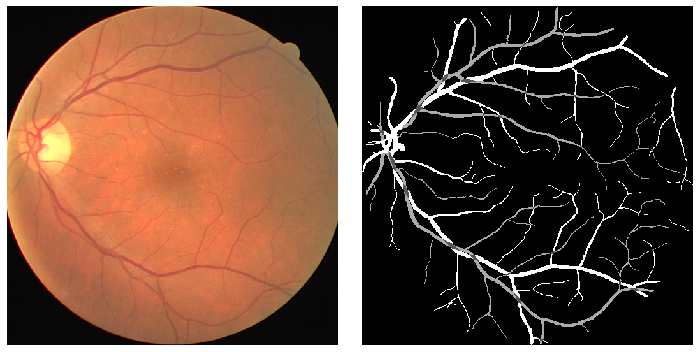

In [629]:
item = ds[0]
im, seg = item['img'], item['seg']

imshow_pair(im.numpy().transpose(1,2,0), seg[0])
torch.unique(seg[0])

In [411]:
import torch
torch.unique(seg[0])

tensor([  0.,  85., 170., 255.])

With the dataset defined, we can now create the dataloader to create data batches. This inherits directly from Pytorch's `DataLoader` class with a few changes to the default constructor arguments. 

In [194]:
from monai.data import DataLoader
from monai.utils import first

In [196]:
batch_size = 10

loader = DataLoader(ds, batch_size, num_workers=5)

batch = first(loader)

print(list(batch.keys()), batch['img'].shape, batch['seg'].shape)

['img', 'seg', 'img_meta_dict', 'seg_meta_dict'] torch.Size([10, 3, 256, 256]) torch.Size([10, 1, 256, 256])
